In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import seaborn as sns


In [ ]:
df = pd.read_csv('/data_min_total.csv')

df

,DateTime_Minute,Bid1_Price,Bid1_Volume,Ask1_Price,Ask1_Volume,Bid2_Price,Bid2_Volume,Ask2_Price,Ask2_Volume,Mid_Price,...,Highest_Price,Trade_Volume,Price_Mean,RSI,MACD,MACD_signal,MACD_hist,KDJ_K,KDJ_D,KDJ_J
0,02/01/2025 07:30,261.84,3384,270.01,2157,254.58,2721,274.22,2231,265.93,...,270.00,62,263.21,NaN,0.000000,0.000000,0.000000,NaN,NaN,NaN
1,02/01/2025 07:31,258.68,2404,263.96,1629,254.83,2480,283.13,1758,261.32,...,267.00,103,260.39,NaN,0.319088,0.063818,0.255271,NaN,NaN,NaN
2,02/01/2025 07:32,263.10,2600,267.75,2118,260.42,3219,271.33,1721,265.43,...,268.67,89,263.94,NaN,0.645222,0.180099,0.465123,NaN,NaN,NaN
3,02/01/2025 07:33,263.02,2006,267.20,2116,260.79,2917,269.99,1979,265.11,...,269.00,86,263.11,NaN,0.494527,0.242984,0.251542,NaN,NaN,NaN
4,02/01/2025 07:34,263.18,3363,268.68,2465,260.36,3879,273.01,2472,265.93,...,270.00,78,263.75,NaN,1.009001,0.396188,0.612814,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63732,01/07/2025 15:55,106.96,2967,172.60,1739,103.34,3004,251.22,1788,139.78,...,112.00,108,106.81,52.45,0.205988,0.290741,-0.084753,68.171042,69.860333,64.792459
63733,01/07/2025 15:56,107.03,4215,159.30,1631,105.33,5083,233.05,1662,133.17,...,111.25,112,107.39,50.00,0.160499,0.264693,-0.104193,68.976773,69.565813,67.798693
63734,01/07/2025 15:57,108.43,2546,148.83,1232,106.87,3560,229.59,1534,128.63,...,112.00,86,107.95,50.31,-0.036513,0.204451,-0.240965,65.592358,68.241328,60.294419
63735,01/07/2025 15:58,108.77,3677,159.01,1805,106.83,3208,256.97,1722,133.89,...,112.00,96,109.21,52.94,0.128637,0.189288,-0.060652,71.179219,69.220625,75.096408


In [ ]:
n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

In [ ]:
train_mp = train_df['Mid_Price']
val_mp = val_df['Mid_Price']
test_mp = test_df['Mid_Price']

In [ ]:
# normalising

train_mean = train_mp.mean()
train_std = train_mp.std()

train_nr = (train_mp - train_mean)/train_std
val_nr = (val_mp - train_mean)/train_std
test_nr = (test_mp - train_mean)/train_std

In [ ]:
def create_sequences(data, input_sequence_length, forecast_horizon):
    X, y = [], []
    for i in range(len(data) - input_sequence_length - forecast_horizon + 1):
        X.append(data[i:(i + input_sequence_length)])
        y.append(data[(i + input_sequence_length):(i + input_sequence_length + forecast_horizon)])
    return np.array(X), np.array(y)

In [ ]:
input_sequence_length = 50
forecast_horizon = 10

X_train, y_train = create_sequences(train_nr, input_sequence_length, forecast_horizon)
X_val, y_val = create_sequences(val_nr, input_sequence_length, forecast_horizon)
X_test, y_test = create_sequences(test_nr, input_sequence_length, forecast_horizon)

# Display the shape of the created sequences for verification
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((44556, 50), (44556, 10), (12689, 50), (12689, 10), (6315, 50), (6315, 10))

In [ ]:
# change the shape to fit the LSTM model

X_train = X_train[:, :, np.newaxis]
X_val = X_val[:, :, np.newaxis]
X_test = X_test[:, :, np.newaxis]


y_train = y_train[:, :, np.newaxis]
y_val = y_val[:, :, np.newaxis]
y_test = y_test[:, :, np.newaxis]

# Display the shape of the created sequences for verification
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((44556, 50, 1),
 (44556, 10, 1),
 (12689, 50, 1),
 (12689, 10, 1),
 (6315, 50, 1),
 (6315, 10, 1))

In [ ]:
# Create tf.data.Dataset objects for the training and test sets

# Pre-batched data sets
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))


train_dataset = train_dataset.batch(64)

val_dataset = val_dataset.batch(64)

test_dataset = test_dataset.batch(64)


In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential

In [ ]:
OUT_STEPS = 10
num_features = 1

lstm_model = Sequential([
    layers.LSTM(32),
    layers.Dense(OUT_STEPS*num_features, kernel_initializer = tf.initializers.zeros()),

    layers.Reshape([OUT_STEPS, num_features])
])

lstm_model.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

In [ ]:
history = lstm_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=40,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
)

Epoch 1/40
1393/1393 [==============================] - 29s 19ms/step - loss: 0.0439 - mean_absolute_error: 0.1347 - val_loss: 0.0803 - val_mean_absolute_error: 0.2345
Epoch 2/40
1393/1393 [==============================] - 27s 19ms/step - loss: 0.0178 - mean_absolute_error: 0.1029 - val_loss: 0.0724 - val_mean_absolute_error: 0.2214
Epoch 3/40
1393/1393 [==============================] - 27s 19ms/step - loss: 0.0177 - mean_absolute_error: 0.1026 - val_loss: 0.0727 - val_mean_absolute_error: 0.2219
Epoch 4/40
1393/1393 [==============================] - 26s 19ms/step - loss: 0.0176 - mean_absolute_error: 0.1024 - val_loss: 0.0663 - val_mean_absolute_error: 0.2118
Epoch 5/40
1393/1393 [==============================] - 26s 19ms/step - loss: 0.0176 - mean_absolute_error: 0.1024 - val_loss: 0.0661 - val_mean_absolute_error: 0.2107
Epoch 6/40
1393/1393 [==============================] - 27s 19ms/step - loss: 0.0175 - mean_absolute_error: 0.1022 - val_loss: 0.0705 - val_mean_absolute_error:

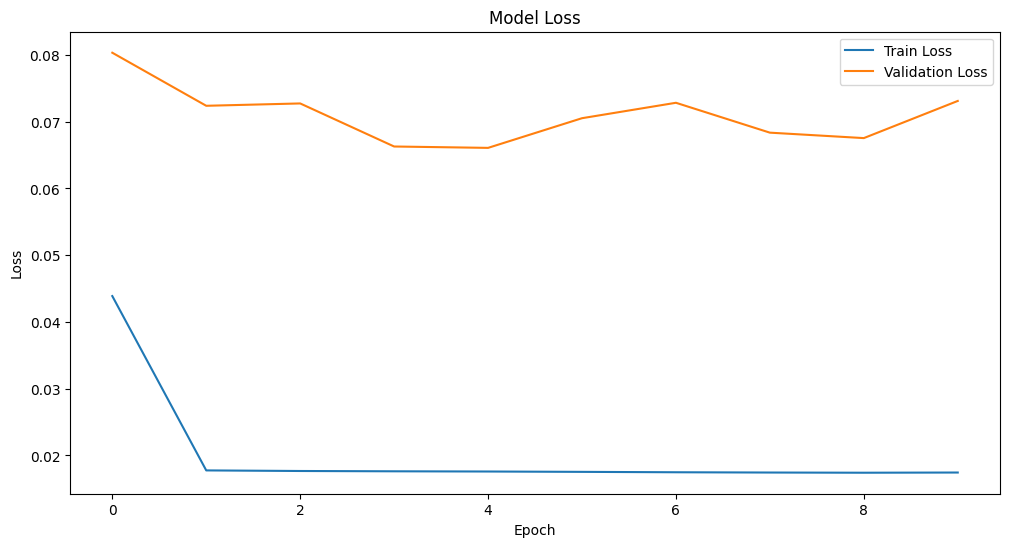

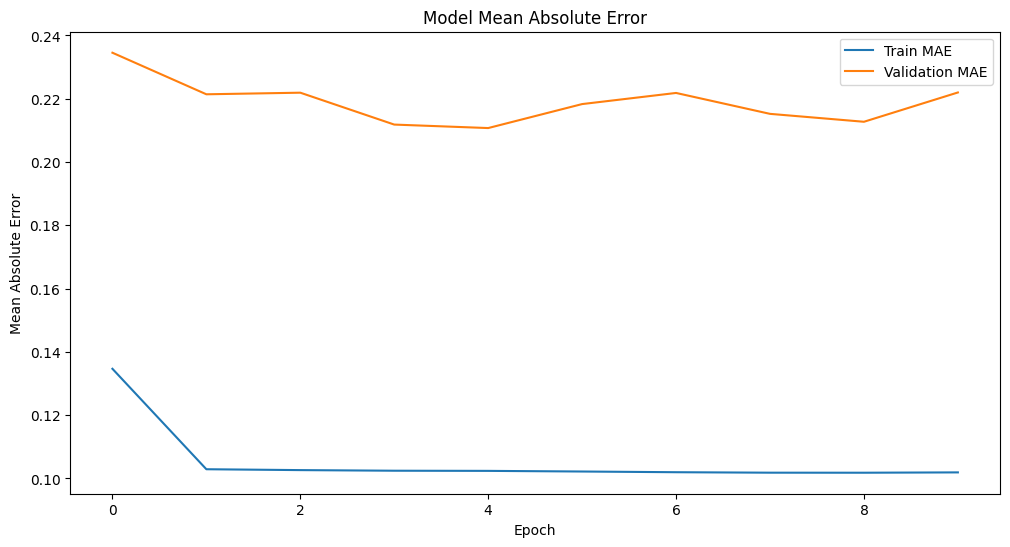

In [ ]:
# Summarize history for loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

# Summarize history for mean absolute error
plt.figure(figsize=(12, 6))
plt.plot(history.history['mean_absolute_error'], label='Train MAE')
plt.plot(history.history['val_mean_absolute_error'], label='Validation MAE')
plt.title('Model Mean Absolute Error')
plt.ylabel('Mean Absolute Error')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

In [ ]:
x_ = np.arange(len(y_test))

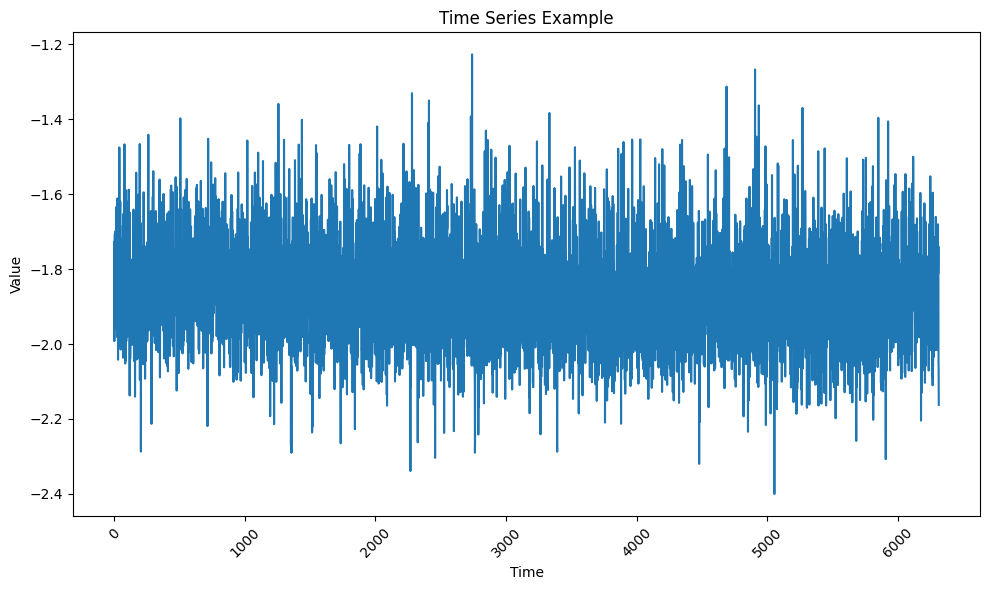

In [ ]:
plt.figure(figsize=(10, 6))  # Optionally set the figure size
plt.plot(x_, y_test[:,0])  # Plot the time series data
plt.title('Time Series Example')  # Add a title
plt.xlabel('Time')  # Label the x-axis
plt.ylabel('Value')  # Label the y-axis
plt.xticks(rotation=45)  # Rotate date labels for better readability
plt.tight_layout()  # Automatically adjust subplot parameters to give specified padding
plt.show()

In [ ]:
y_pred = lstm_model.predict(X_test)

198/198 [==============================] - 2s 6ms/step


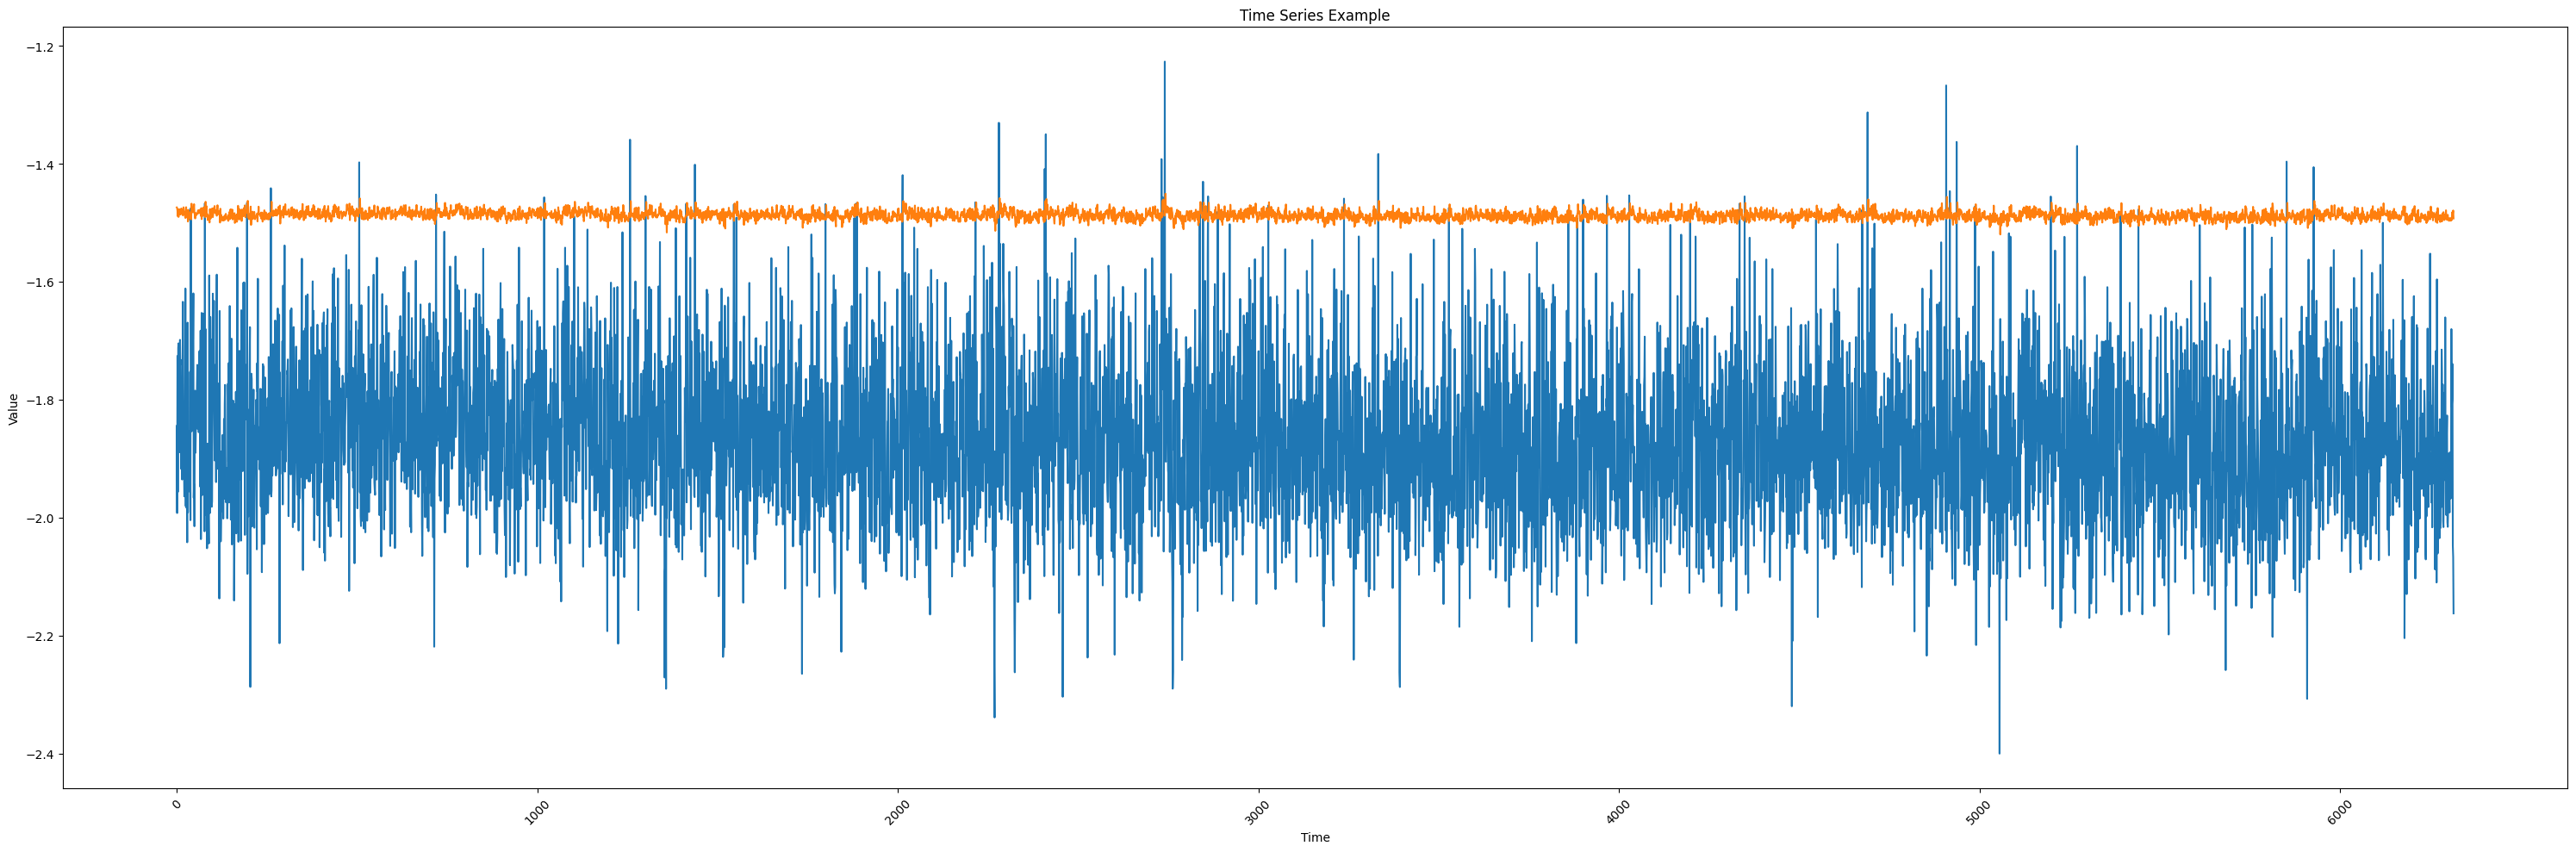

In [ ]:
plt.figure(figsize=(30, 10))  # Optionally set the figure size
plt.plot(x_, y_test[:,0])  # Plot the time series data
plt.plot(x_, y_pred[:,0])
plt.title('Time Series Example')  # Add a title
plt.xlabel('Time')  # Label the x-axis
plt.ylabel('Value')  # Label the y-axis
plt.xticks(rotation=45)  # Rotate date labels for better readability
plt.tight_layout()  # Automatically adjust subplot parameters to give specified padding
plt.show()

In [ ]:
# LSTM 2 (more complex 2 lstm layers)

lstm_model2 = Sequential([
    layers.LSTM(50, activation = 'relu', return_sequences=True),
    layers.LSTM(50, activation='relu'),
    layers.Dense(OUT_STEPS*num_features, kernel_initializer = tf.initializers.zeros()),

    layers.Reshape([OUT_STEPS, num_features])
])

lstm_model2.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

In [ ]:
history = lstm_model2.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=40,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
)

Epoch 1/40
1393/1393 [==============================] - 60s 41ms/step - loss: 0.0455 - mean_absolute_error: 0.1352 - val_loss: 0.0207 - val_mean_absolute_error: 0.1158
Epoch 2/40
1393/1393 [==============================] - 57s 41ms/step - loss: 0.0181 - mean_absolute_error: 0.1044 - val_loss: 0.0262 - val_mean_absolute_error: 0.1313
Epoch 3/40
1393/1393 [==============================] - 56s 40ms/step - loss: 0.0180 - mean_absolute_error: 0.1040 - val_loss: 0.0278 - val_mean_absolute_error: 0.1348
Epoch 4/40
1393/1393 [==============================] - 57s 41ms/step - loss: 0.0180 - mean_absolute_error: 0.1038 - val_loss: 0.0620 - val_mean_absolute_error: 0.2054
Epoch 5/40
1393/1393 [==============================] - 58s 41ms/step - loss: 0.0179 - mean_absolute_error: 0.1036 - val_loss: 0.0379 - val_mean_absolute_error: 0.1587
Epoch 6/40
1393/1393 [==============================] - 56s 40ms/step - loss: 0.0178 - mean_absolute_error: 0.1032 - val_loss: 0.0362 - val_mean_absolute_error:

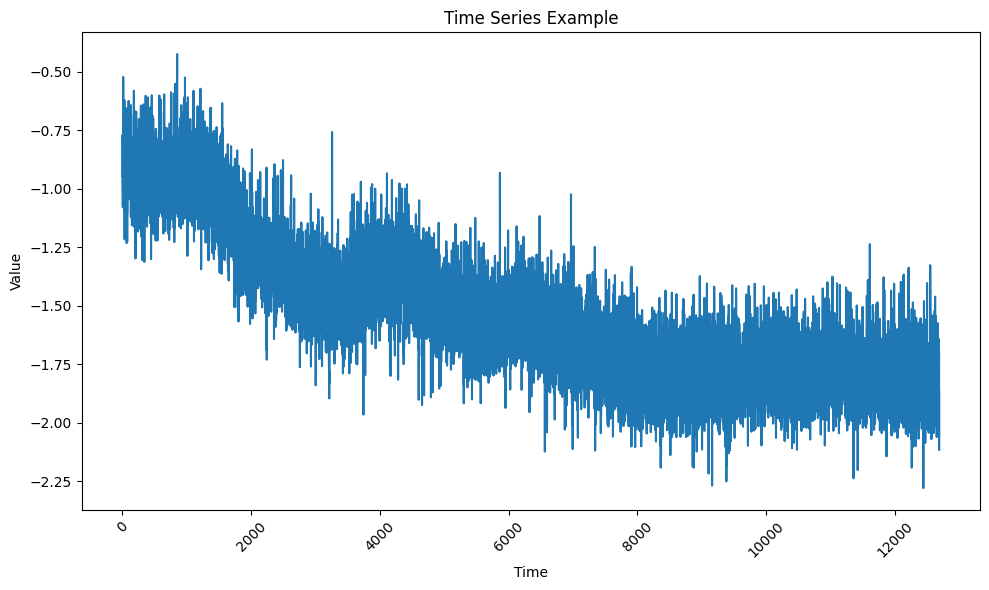

In [ ]:
# Check the result on validation set

x__ = np.arange(len(y_val))

plt.figure(figsize=(10, 6))  # Optionally set the figure size
plt.plot(x__, y_val[:,0])  # Plot the time series data
plt.title('Time Series Example')  # Add a title
plt.xlabel('Time')  # Label the x-axis
plt.ylabel('Value')  # Label the y-axis
plt.xticks(rotation=45)  # Rotate date labels for better readability
plt.tight_layout()  # Automatically adjust subplot parameters to give specified padding
plt.show()


In [ ]:
y_pred_val = lstm_model2.predict(X_val)

397/397 [==============================] - 6s 13ms/step


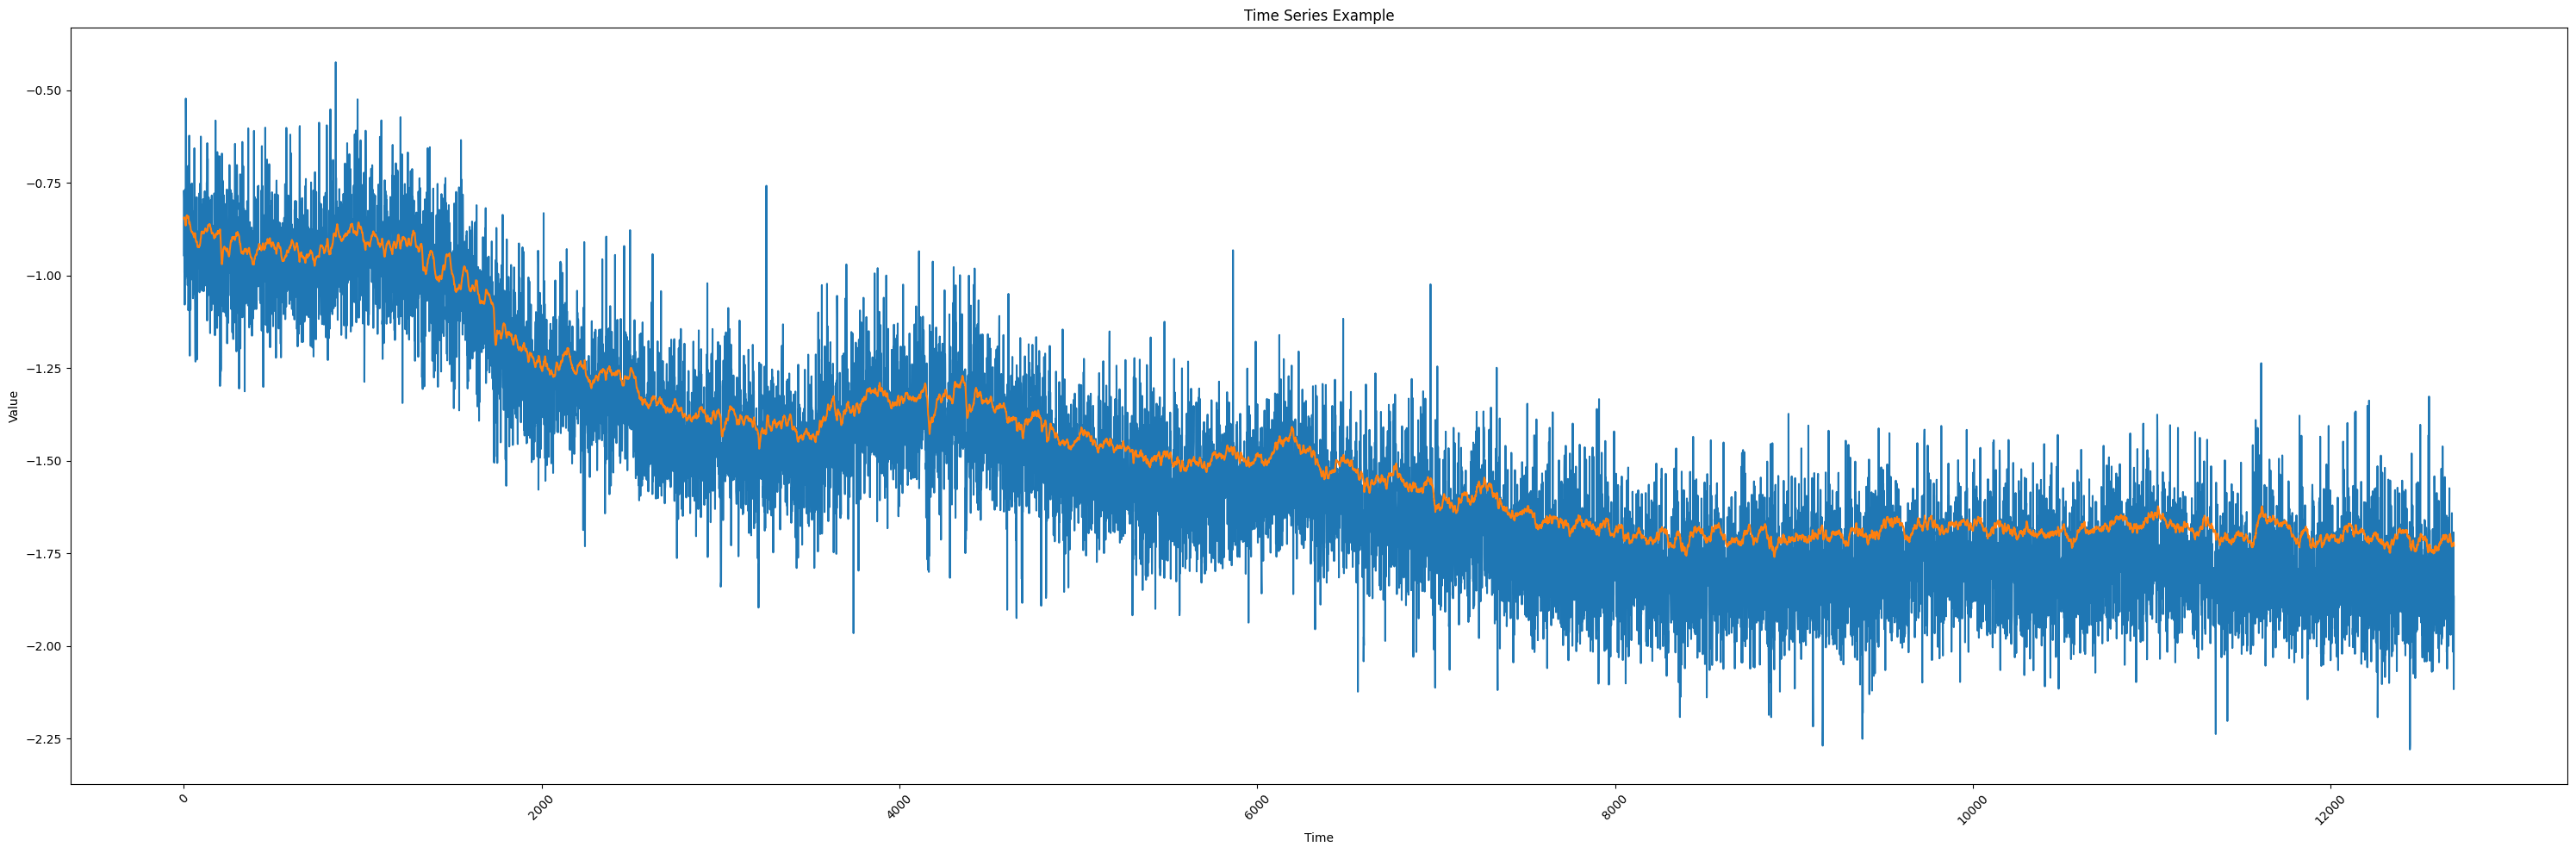

In [ ]:
plt.figure(figsize=(30, 10))  # Optionally set the figure size
plt.plot(x__, y_val[:,0])  # Plot the time series data
plt.plot(x__, y_pred_val[:,0])
plt.title('Time Series Example')  # Add a title
plt.xlabel('Time')  # Label the x-axis
plt.ylabel('Value')  # Label the y-axis
plt.xticks(rotation=45)  # Rotate date labels for better readability
plt.tight_layout()  # Automatically adjust subplot parameters to give specified padding
plt.show()

In [ ]:
y_pred2 = lstm_model2.predict(X_test)

198/198 [==============================] - 3s 13ms/step


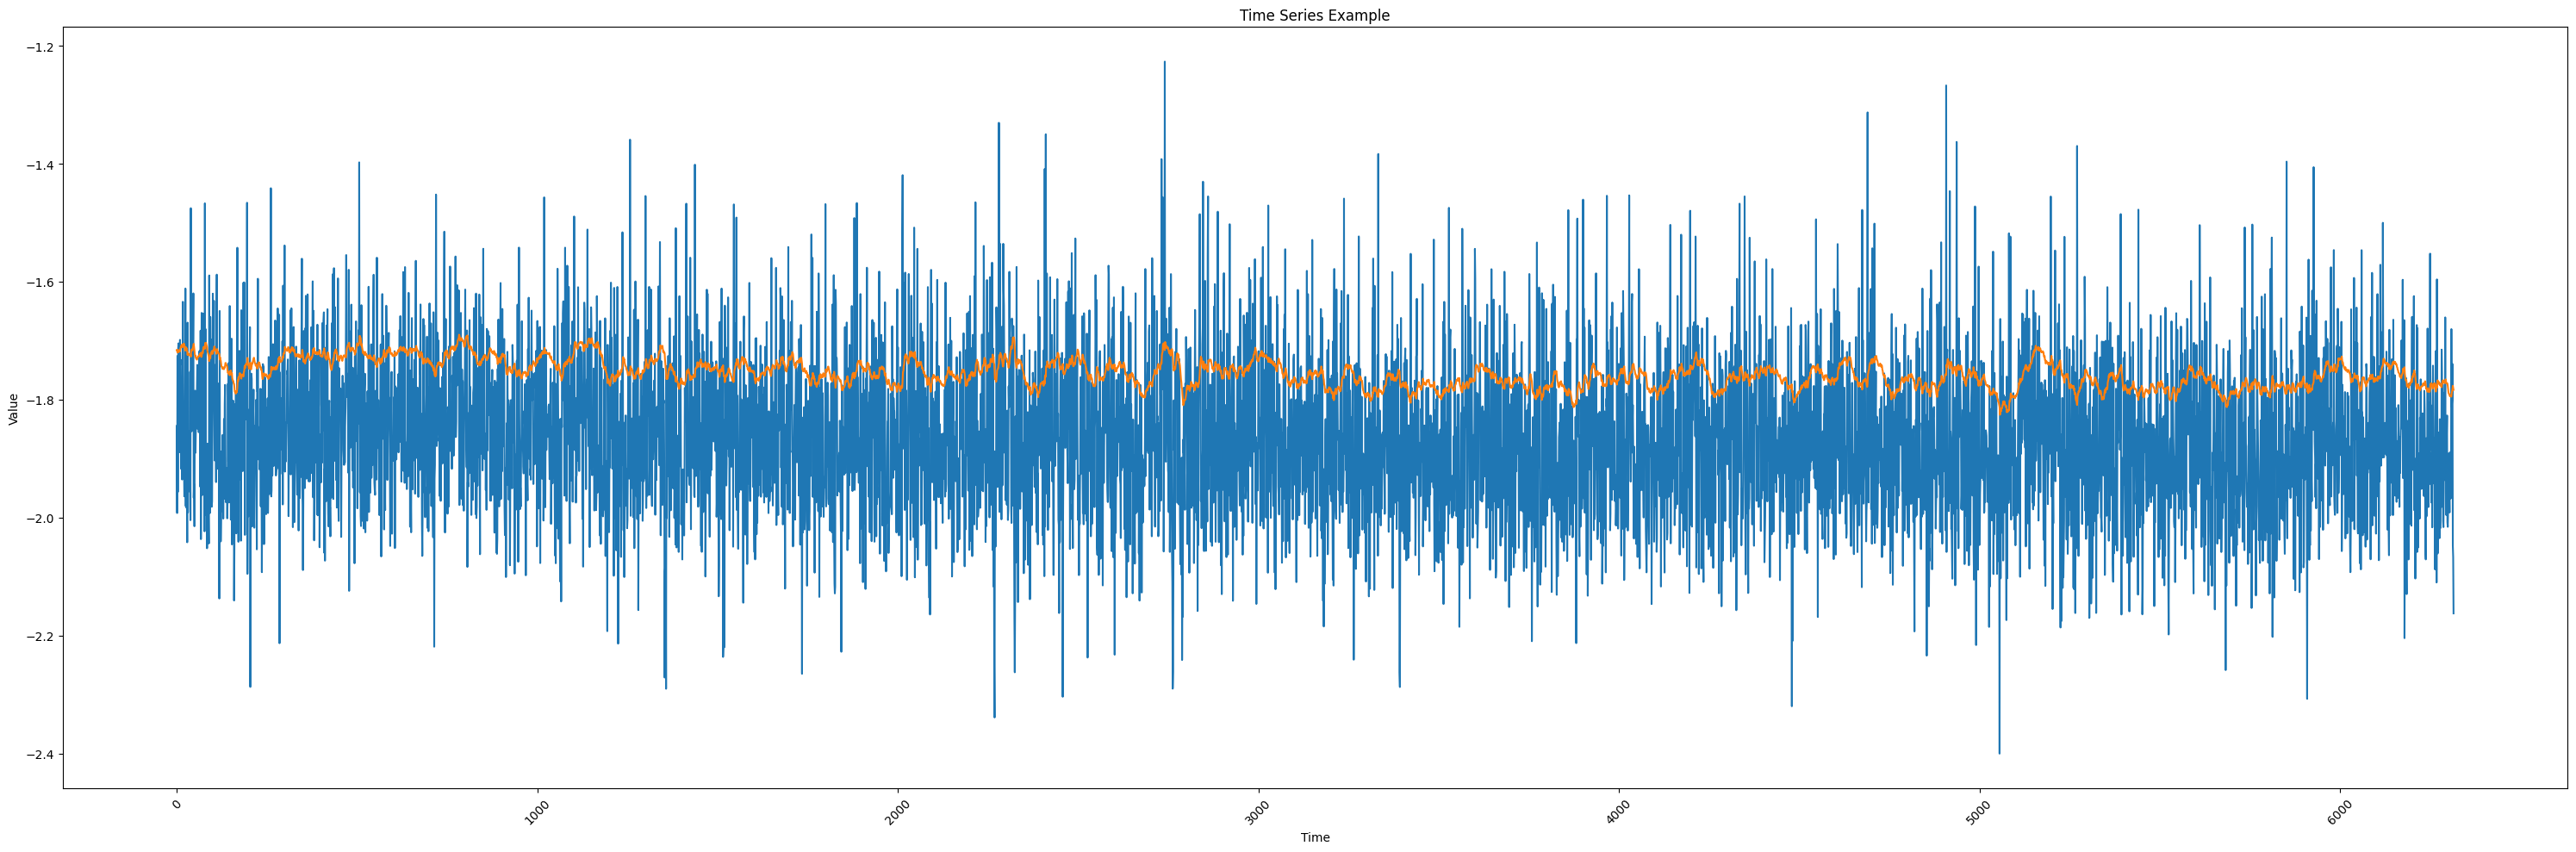

In [ ]:
plt.figure(figsize=(30, 10))  # Optionally set the figure size
plt.plot(x_, y_test[:,0])  # Plot the time series data
plt.plot(x_, y_pred2[:,0])
plt.title('Time Series Example')  # Add a title
plt.xlabel('Time')  # Label the x-axis
plt.ylabel('Value')  # Label the y-axis
plt.xticks(rotation=45)  # Rotate date labels for better readability
plt.tight_layout()  # Automatically adjust subplot parameters to give specified padding
plt.show()

In [ ]:
# lstm 3
lstm_model3 = Sequential([
    layers.LSTM(50, activation = 'relu', return_sequences=True),
    layers.LSTM(50, activation='relu', return_sequences=True),
    layers.LSTM(50, activation='relu'),
    layers.Dense(OUT_STEPS*num_features, kernel_initializer = tf.initializers.zeros()),

    layers.Reshape([OUT_STEPS, num_features])
])

lstm_model3.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

In [ ]:
history = lstm_model3.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=40,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
)

Epoch 1/40
1393/1393 [==============================] - 87s 62ms/step - loss: 0.0182 - mean_absolute_error: 0.1047 - val_loss: 0.6459 - val_mean_absolute_error: 0.6037
Epoch 2/40
1393/1393 [==============================] - 87s 63ms/step - loss: 0.0181 - mean_absolute_error: 0.1041 - val_loss: 0.6659 - val_mean_absolute_error: 0.6530
Epoch 3/40
1393/1393 [==============================] - 84s 60ms/step - loss: 0.0181 - mean_absolute_error: 0.1042 - val_loss: 0.1290 - val_mean_absolute_error: 0.2904
Epoch 4/40
1393/1393 [==============================] - 84s 61ms/step - loss: 0.0178 - mean_absolute_error: 0.1034 - val_loss: 0.1082 - val_mean_absolute_error: 0.2731
Epoch 5/40
1393/1393 [==============================] - 87s 62ms/step - loss: 0.0179 - mean_absolute_error: 0.1034 - val_loss: 0.0437 - val_mean_absolute_error: 0.1712
Epoch 6/40
1393/1393 [==============================] - 85s 61ms/step - loss: 0.0179 - mean_absolute_error: 0.1035 - val_loss: 0.0531 - val_mean_absolute_error:

In [ ]:
y_pred_val2 = lstm_model3.predict(X_val)

Exception ignored in: <function _xla_gc_callback at 0x79e9d839a200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 97, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 


397/397 [==============================] - 8s 18ms/step


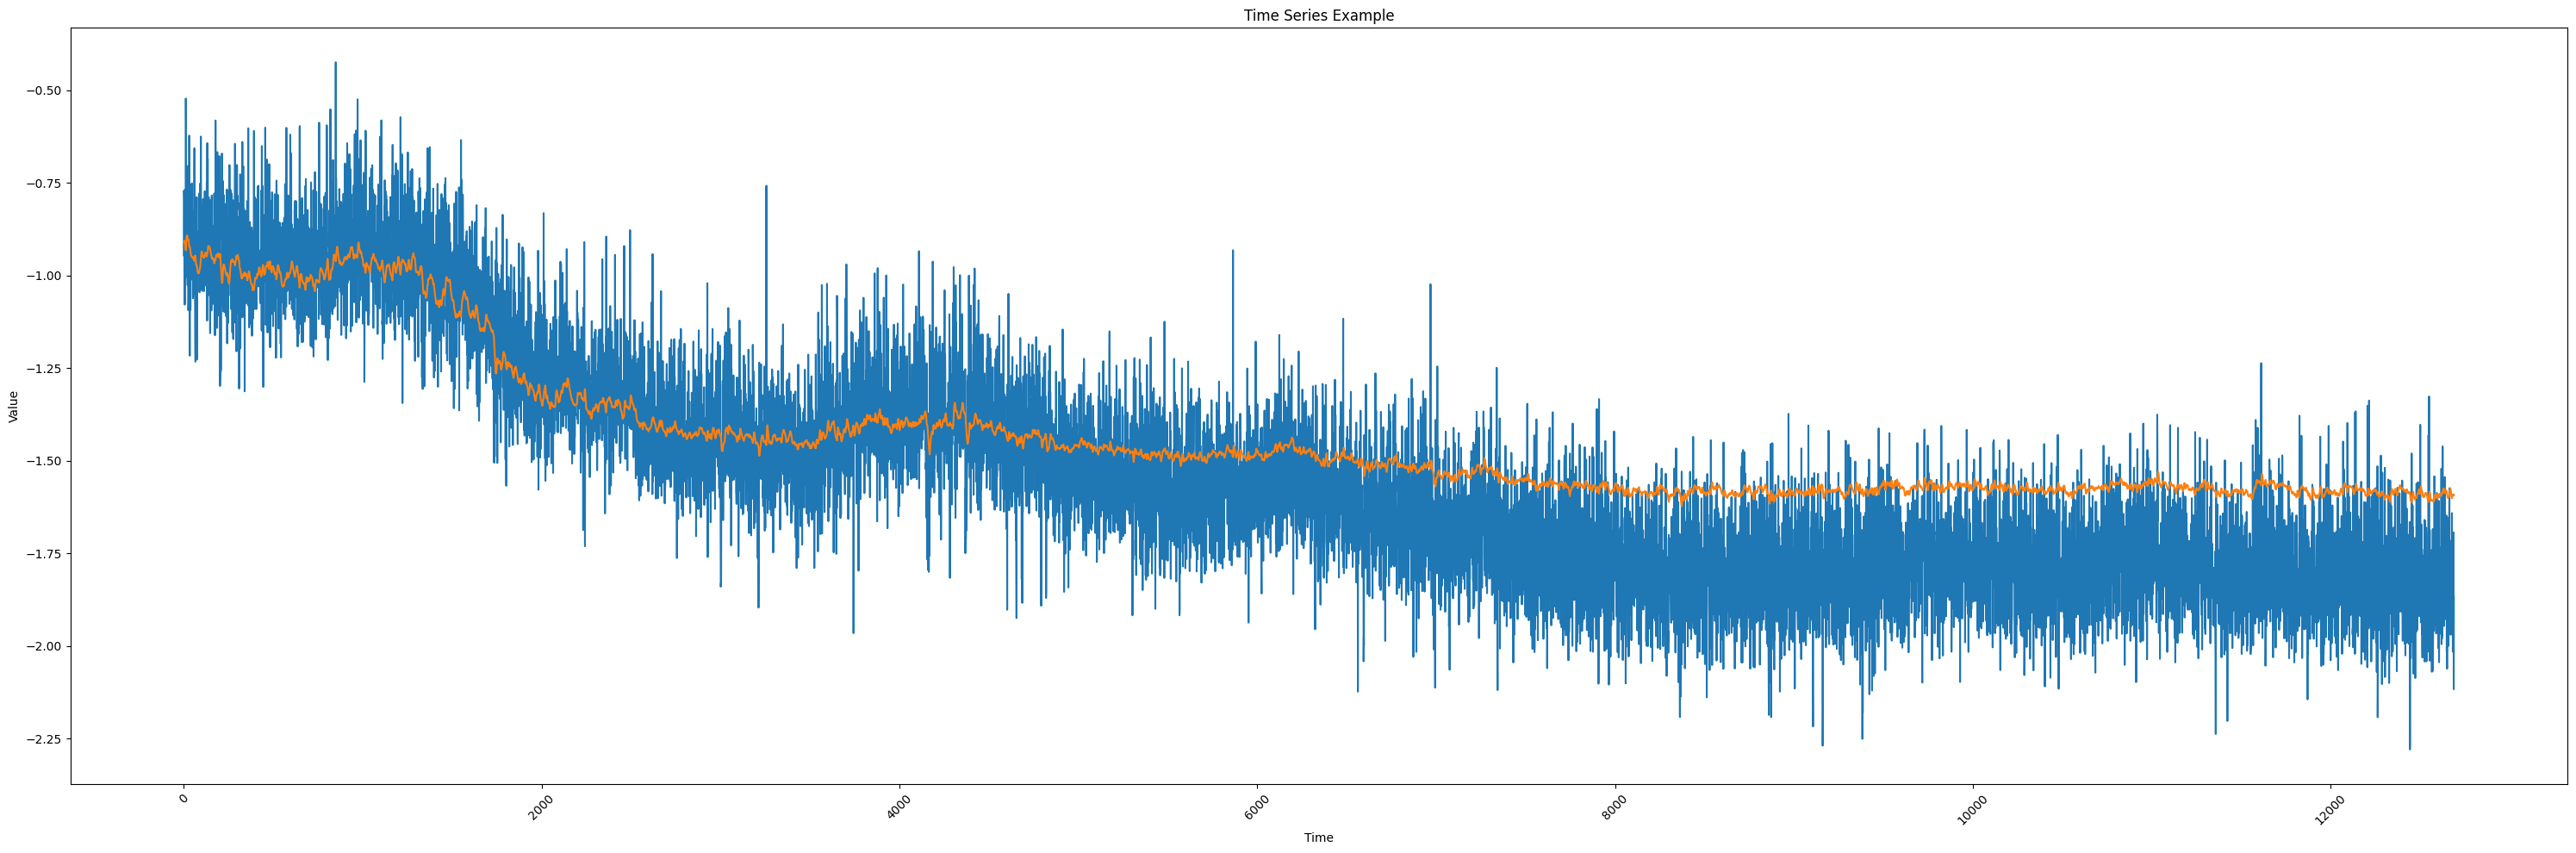

In [ ]:
plt.figure(figsize=(30, 10))  # Optionally set the figure size
plt.plot(x__, y_val[:,0])  # Plot the time series data
plt.plot(x__, y_pred_val2[:,0])
plt.title('Time Series Example')  # Add a title
plt.xlabel('Time')  # Label the x-axis
plt.ylabel('Value')  # Label the y-axis
plt.xticks(rotation=45)  # Rotate date labels for better readability
plt.tight_layout()  # Automatically adjust subplot parameters to give specified padding
plt.show()

In [ ]:
y_pred3 = lstm_model3.predict(X_test)

198/198 [==============================] - 4s 19ms/step


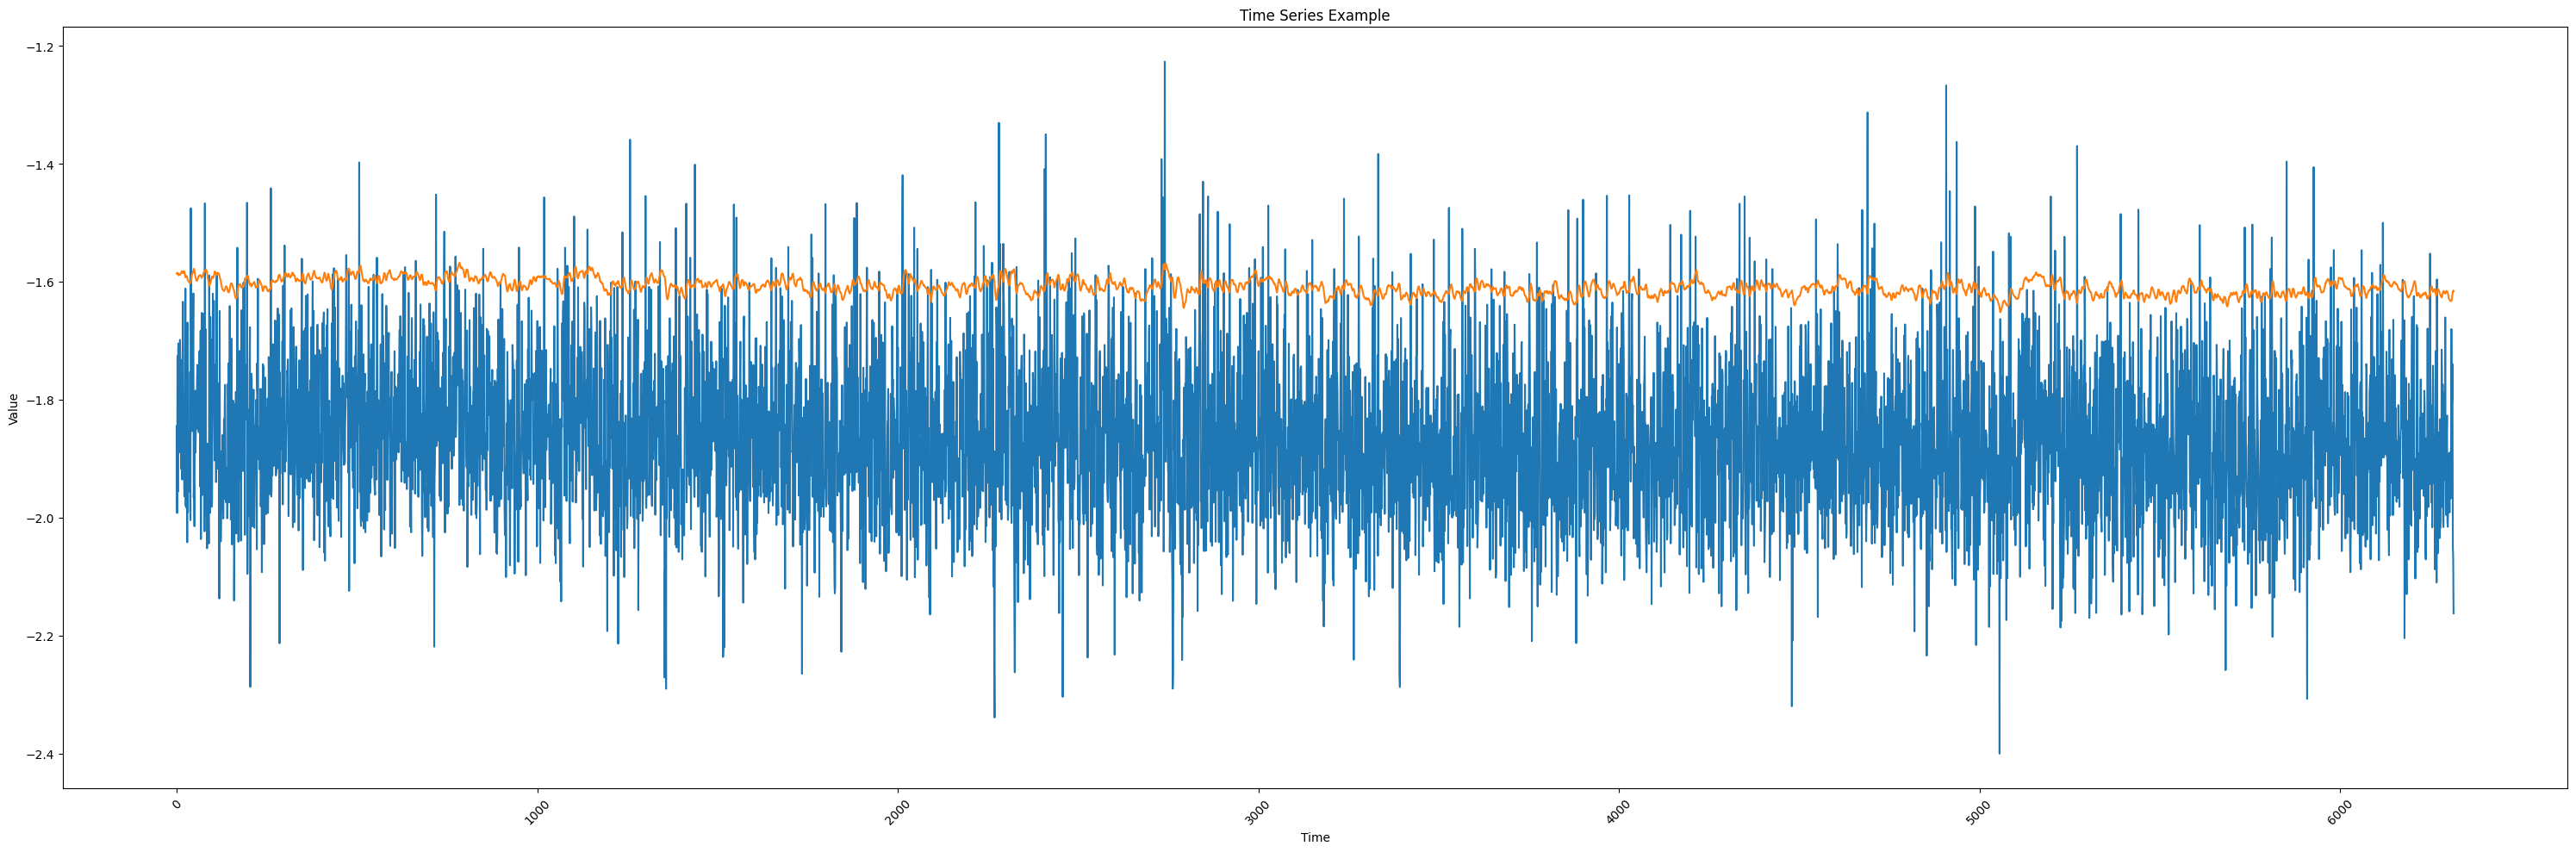

In [ ]:
plt.figure(figsize=(30, 10))  # Optionally set the figure size
plt.plot(x_, y_test[:,0])  # Plot the time series data
plt.plot(x_, y_pred3[:,0])
plt.title('Time Series Example')  # Add a title
plt.xlabel('Time')  # Label the x-axis
plt.ylabel('Value')  # Label the y-axis
plt.xticks(rotation=45)  # Rotate date labels for better readability
plt.tight_layout()  # Automatically adjust subplot parameters to give specified padding
plt.show()